# Counting Clumps

This notebook aims to simulate a counting experiment for non interacting particles showing some small structure, i.e not necessarily homegenously distributed in space.

In [1]:
import random
import numpy as np
import statistics
import matplotlib.pyplot as plt
import scipy.fftpack
from scipy.fftpack import fft, fftfreq, ifft
from scipy.stats import pearsonr, ttest_ind
from statsmodels.graphics import tsaplots
import scipy.stats as st
from scipy import stats
import scipy as sp
from scipy.stats import poisson
import warnings
warnings.filterwarnings(action='ignore')

random.seed(10000)

## Content

1. Creating signal : random Poisson process + random clumps
2. FFT & Power spectrum 
 -  Analysis for a single run
 - Adding stadistics
3. Testing Null-Hypothesis
 - Parametric test
 - Non parametric test
4. Setting significance 
5. Significance evolution
6. Characterizing the spectrum 
7. Numerical expresions 

## 1. SIGNAL

In [10]:
def Signal(N_events,λ, T, pc, lam):
    '''The function generates a random poisson process, then given a certain period, and probability of occurrence,
    the function takes from an additional poisson distribution events randomly and adds them as overdensities
    to the random process.
    
    The inputs of this function are:
    
     N_events:      total number of events to generate
     λ:             random poisson process rate
     T:             period of the overdensities.
     pc:            probability of occurrence of the overdensities
     lam:           overdensity rates'''
    
    Event_num = []                    # Iteration
    Inter_event_times = []            # Inter times
    Event_times = []                  # Absolute time
    Event_time = 0                    # Starter
    limit = N_events

#_______________________________#GENERATE_TIME_INTERVALS#__________________________________#
   
    for i in range(N_events):      
        Event_num.append(i)
        p = random.random()
        Inter_event_time = -np.log(1.0 - p) / λ
        Event_time = Event_time + Inter_event_time
        Inter_event_times.append(Inter_event_time)
        Event_times.append(Event_time)
        
    Interval_nums = []
    Num_events_in_interval = []
    Interval_num = 1
    N_events = 0
    
#________________________________#GENERATE_TIME_EVENTS#____________________________________#   
    for i in range(len(Event_times)):
        Event_time = Event_times[i]
        if (np.sum(Num_events_in_interval) <= limit):
            if (Event_time < Interval_num):
                if(len(Interval_nums)% T ==0):
                    r = random.random()
                    if (r <= pc):
                        s =np.random.poisson(lam)
                        N_events +=s
                    else:
                        N_events +=1
                else:
                    N_events += 1
            else:
                Interval_nums.append(Interval_num)
                Num_events_in_interval.append(N_events)

                Interval_num += 1
                N_events =0 # This counter allows you to have zero detections when set to zero.
        else: 
            Num_events_in_interval.append(0)
            Interval_nums.append(Interval_num)
            Interval_num += 1
    return Interval_nums, Num_events_in_interval,Event_num

In [11]:
# Checking
N_events = 500
λ = 2.0
T = 3.0
pc = 0.15
lam = 20
signal = Signal(N_events,λ, T, pc, lam)

In [12]:
signal[0][-1], len(signal[0])

(246, 246)

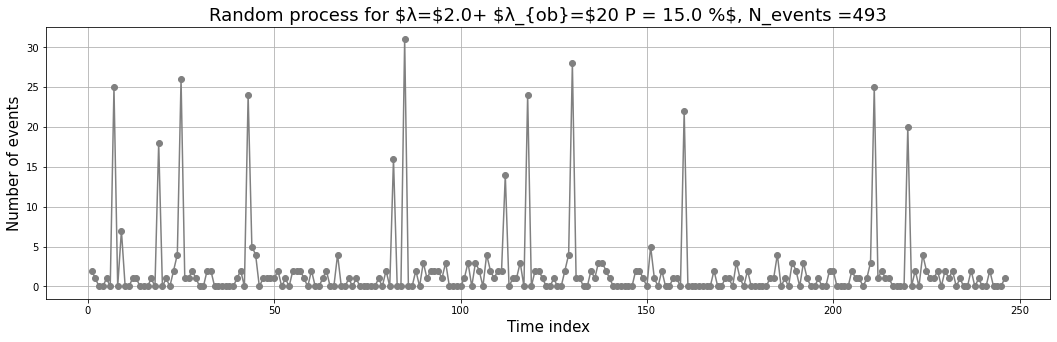

In [13]:
plt.figure(figsize= (18,5))
plt.plot(signal[0], signal[1],'-o', color='0.5')
plt.title(r'Random process for $λ=$'+str(λ) + '+ $λ_{ob}=$'+str(lam) + ' P = '+str(pc*100) +' %$, N_events ='+str(np.sum(signal[1])), size = 18)
plt.ylabel('Number of events', size=15)
plt.xlabel('Time index', size=15)
plt.grid()
#plt.savefig('signal22.jpg', format='jpg')

## 2. FFT & Power Spectrum 

### 2.1 Analysis for a single run

In [14]:
Fstime = len(signal[0])
sfreq = fftfreq(Fstime)        # Creates all the necesary frequencies 
sImask = sfreq >= 0            # Ignoring half the values
smask = sfreq > 0              # Ignoring half the values 

# Signal
s1 = signal[1]

# Fourier transform
sFourier =fft(s1)

#Power Spectrum 
sPower = 2.0*(np.abs(sFourier)/Fstime)**2.0 

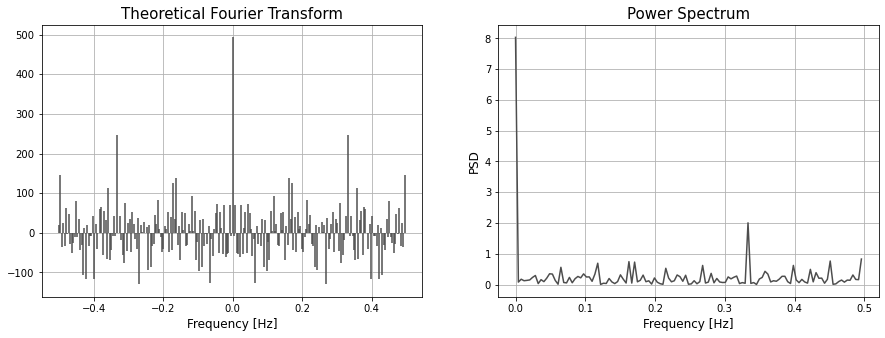

In [15]:
# Checking

fig,axs = plt.subplots(1,2, figsize=(15,5))
axs[0].vlines(sfreq,0, sFourier, color = '0.3')
axs[0].set_xlabel('Frequency [Hz]', size=12)
axs[0].set_title('Theoretical Fourier Transform', size=15)
axs[0].grid()
axs[1].plot(sfreq[sImask], sPower[sImask], color = '0.3')
axs[1].set_xlabel('Frequency [Hz]', size=12)
axs[1].set_ylabel('PSD', size=12)
axs[1].set_title('Power Spectrum', size=15)
axs[1].grid()

### 2.2 Analysis for N samples: adding statistics 

In [16]:
def Stats(N,N_events,λ, T, pc, lam):
    '''This function generates N times the sample of equal lenth'''
    TimeSample =[]
    BackSample = []
    
    for i in range(N):
        Time, B ,numm= Signal(N_events,λ, T, pc, lam)
        TimeSample.append(Time)
        BackSample.append(B)
    
        
    Cut = len(min(TimeSample))
    Time_cut = [TimeSample[i][0:Cut] for i in range(N)]
    Back_cut = [BackSample[i][0:Cut] for i in range(N)]
    
    return Time_cut[0], Back_cut

In [17]:
#Check 
N = 500
N_events = 500
λ= 2.0 
T = 3.0
pc= 0.10
lam = 20
Sampling = Stats(N,N_events,λ, T, pc, lam)

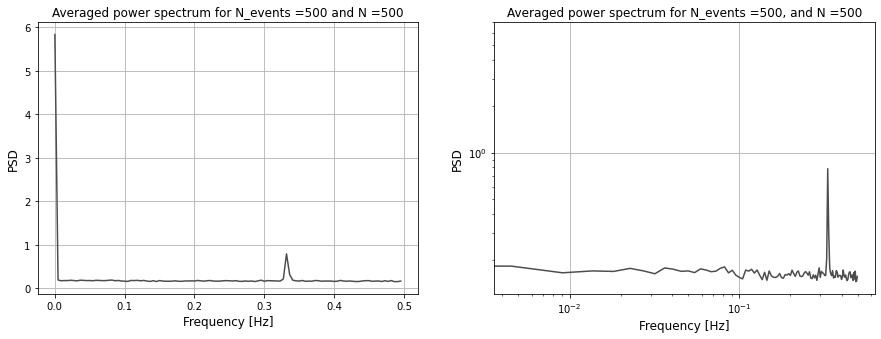

In [18]:
# Averaged Spectrum 

IHN_e= len(Sampling[0])
IHfreq = fftfreq(IHN_e)       
IHmask = IHfreq >= 0
mask = IHfreq > 0
SFourier =np.array([fft(Sampling[1][k]) for k in range(N)])
SignalPower =[2.0*np.abs(SFourier[k]/IHN_e)**2.0 for k in range(N)]
data1 = np.array(SignalPower).mean(axis=0) 

#Plot
fig,axs = plt.subplots(1,2, figsize=(15,5))
axs[0].plot(IHfreq[IHmask], data1[IHmask], color = '0.3')
axs[0].set_title('Averaged power spectrum for N_events ='+str(N_events)+' and N ='+str(N), size=12)
axs[0].set_xlabel('Frequency [Hz]', size=12)
axs[0].set_ylabel('PSD', size=12)
axs[0].grid();
axs[1].loglog(IHfreq[IHmask], data1[IHmask], color = '0.3')
axs[1].set_title('Averaged power spectrum for N_events ='+str(N_events)+ ', and N ='+str(N), size=12)
axs[1].set_xlabel('Frequency [Hz]', size=12)
axs[1].set_ylabel('PSD', size=12)
axs[1].grid();

In [19]:
std = data1[IHmask].std()
mean = data1[IHmask].mean()
maxim = data1[mask].max()
SE = (maxim - mean)/std
false = 1-(1-sp.exp(-maxim))**2

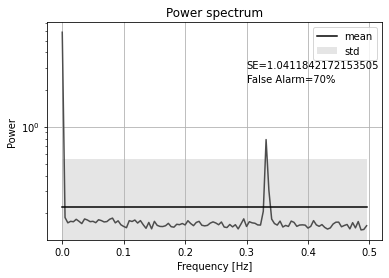

In [20]:
plt.semilogy(IHfreq[IHmask], data1[IHmask], '-', color='0.3')

plt.fill_between(IHfreq[IHmask],std,-std, alpha=0.2, edgecolor='b', facecolor='0.5',
    linewidth=0, label = 'std')
plt.semilogy(IHfreq[IHmask], [mean]*len(IHfreq[IHmask]), 'k', label='mean')
plt.text(0.3, 3.0e0, r'SE='+str(SE) )
plt.text(0.3, 2.3e0, r'False Alarm='+str(int(false*100))+r'%')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power')
plt.title('Power spectrum')
plt.legend(loc='best')
plt.grid()

## 3. Testing Null Hypothesis 

The theoretical approach is going to be the baseline for further statistical testing. The average spectrum and the theoretical spectrum from the baseline obtained in Counting experiment 1.0  are compared.

$H_{0}:$ the power spectrum corresponds to gaussian white noise. \
$H_{1}:$ the power spectrum does not corresponds to gaussian white noise.


In [21]:
def delta(λ,n):
    function = []
    for i in range(len(n)):
        if np.array(n[i]).any() == 0:
            function.append(4*λ)
        else:
            function.append(0)
    return function

### 3.1 Test for a single case

Here we check the performance of the parametric and non parametric test over the sample and the baselines.

In [22]:
def time_trials1( N_events,λ,T, pc, lam):
    
    '''This function generates average spectrums for different time lengths and compere the
    result with the theoretical white noise spectrum and with the power spectra generated 
    directly from poisson samples.'''
    
    T1_pvalue = []                             #store p-values from t-test 1.
    T2_pvalue = []                             #store p-values from t-test 2.
    MW1_pvalue = []                            #store p-values from Mann-whitney test 1.
    MW2_pvalue = []                            #store p-values from Mann-whitney test 2. 
    tim = []
    prueba = []


    for i in range(len(N_events)):
        Inter_nums, sig, inter= Signal(N_events[i],λ, T, pc, lam)
        
        IHN_e= len(Inter_nums)
        IHfreq = fftfreq(IHN_e)       
        IHmask = IHfreq >= 0
        SFourier =fft(sig)
        SignalPower =2.0*np.abs(SFourier/IHN_e)**2.0 
        prueba.append(SignalPower)
        
        #Analytical
        
        Back = poisson.rvs(mu=λ, size= Inter_nums[-1])
        IHN= len(Back)
        Bfreq = fftfreq(IHN)       
        Bmask = Bfreq >= 0
        BFourier = fft(Back)
        BackPower =2.0*np.abs(BFourier/IHN)**2.0 
        
        # Theoretical 
        
        PowerT =delta(λ, IHfreq)

        statt1, pt1 = ttest_ind(BackPower[Bmask], SignalPower[IHmask],  equal_var='false')
        statt2, pt2 = ttest_ind(delta(λ,IHfreq[IHmask]), SignalPower[IHmask], equal_var='false')
        statm1, pm1 = stats.mannwhitneyu( BackPower[Bmask], SignalPower[IHmask])
        statm2, pm2 = stats.mannwhitneyu(delta(λ,IHfreq[IHmask]), SignalPower[IHmask])
    
        T1_pvalue.append(pt1)
        T2_pvalue.append(pt2)
        MW1_pvalue.append(pm1)
        MW2_pvalue.append(pm2)
        tim.append(IHN_e)
        
        
    return T1_pvalue,T2_pvalue, MW1_pvalue, MW2_pvalue,tim

In [23]:
# Check prueba 
N_events = [100, 200, 300, 400, 500, 800]
λ = 2.0
T = 3.0
pc= 0.10
lam = 20
N = 5000
Testeando1 = time_trials1( N_events,λ,T, pc, lam)

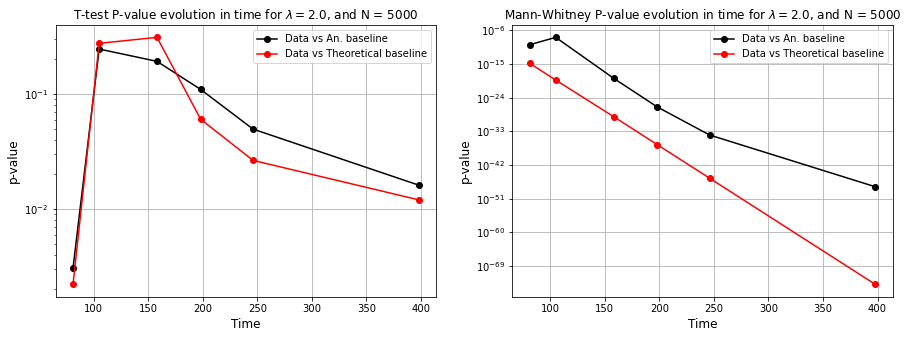

In [24]:
fig,axs = plt.subplots(1,2, figsize=(15,5))
axs[0].semilogy(Testeando1[-1], Testeando1[0], 'ko-', label= 'Data vs An. baseline')
axs[0].semilogy(Testeando1[-1], Testeando1[1], 'ro-', label = 'Data vs Theoretical baseline')
axs[0].set_xlabel('Time', size= 12)
axs[0].set_ylabel('p-value',  size= 12)
axs[0].set_title('T-test P-value evolution in time for $λ=$'+str(λ)+', and N = '+str(N), size= 12)
axs[0].grid()
axs[0].legend()
axs[1].semilogy(Testeando1[-1], Testeando1[2], 'ko-', label= 'Data vs An. baseline')
axs[1].semilogy(Testeando1[-1], Testeando1[3], 'ro-', label= 'Data vs Theoretical baseline')
axs[1].set_xlabel('Time', size= 12)
axs[1].set_ylabel('p-value',  size= 12)
axs[1].set_title('Mann-Whitney P-value evolution in time for $λ=$'+str(λ)+', and N = '+str(N), size= 12)
axs[1].grid()
axs[1].legend();

### 3.2 P vs $\lambda_{ov}$ for $5\sigma$

First, the relation between  P vs $\lambda_{ov}$ is explored. The objective is to find combinations of those parameters in order to have a p-value equivalent to  $5\sigma$ significance, i.e p-value $\approx 10^{-7}$.

In [29]:
def p_l(N, N_events,λ, T, pc, lam):
    pvalue = []
    pv = []
    times = []
    for i in range(len(pc)):
        time,back=Stats(N, N_events,λ, T, pc[i], lam)
        
        #Signal analysis 
        IHN_e= len(time)
        IHfreq = fftfreq(IHN_e)       
        IHmask = IHfreq >= 0
        mask = IHfreq > 0
        SFourier =np.array([fft(back[k]) for k in range(N)])
        SignalPower =[2.0*np.abs(SFourier[k]/IHN_e)**2.0 for k in range(N)]
        data1 = np.array(SignalPower).mean(axis=0) 
        
        # Analytical 
        
        analytical = poisson.rvs(mu=λ, size= time[-1])
        IHN= len(analytical)
        Afreq = fftfreq(IHN)       
        Amask = Afreq >= 0
        AFourier = fft(analytical)
        APower =2.0*np.abs(AFourier/IHN)**2.0 
    
        stat, p = ttest_ind(APower[Amask], data1[IHmask],equal_var='false' )
        stat1, p1 = stats.mannwhitneyu(APower[Amask], data1[IHmask])#, alternative='less')
    
        pvalue.append(p1)
        pv.append(p)
        times.append(IHN_e)
        
        
    return pvalue,pv, times


In [30]:
lam =  list(range(1,100))
r = np.linspace(0,1,100)
N = 100
def plamb(N, N_events):
    npv=[]
    peak10 =[]
    ov =[]
    prob =[]
    time10 = []
    for i in range(len(lam)):
        pvalue, pv,times= p_l(N, N_events,λ, T, r, lam[i])
        npv.append(pvalue)
    for i in range(len(lam)):
        for j in range(len(r)):
            if (1e-7<npv[i][j]<=1e-6):
                peak10.append(npv[i][j])
                prob.append(j)
                ov.append(i/2)
    prob1 = [r[prob[i]] for i in range(len(prob))]
    return prob1, ov, npv

Checking ...

In [31]:
teste11 = plamb(N,50)
teste22 = plamb(N,100)
teste33 = plamb(N,200)

In [34]:
#Saving data in dataframes and eliminating duplicates.

import pandas as pd

df = pd.DataFrame({'Over':teste11[1],'Prob':teste11[0]})
df2 = pd.DataFrame({'Over':teste22[1],'Prob':teste22[0]})
df3 = pd.DataFrame({'Over':teste33[1],'Prob':teste33[0]})
df = df.drop_duplicates('Over')
df2 = df2.drop_duplicates('Over')
df3 = df3.drop_duplicates('Over')
df=df.sort_values(by='Prob')
df2=df2.sort_values(by='Prob')
df3=df3.sort_values(by='Prob')

In [36]:
# Fitting the scatter data

curve_fit= np.polyfit(df['Prob'], np.log( df['Over']), 1)
curve_fit2= np.polyfit(df2['Prob'], np.log( df2['Over']), 1)
curve_fit3= np.polyfit(df3['Prob'], np.log( df3['Over']), 1)
curve_fit.tolist(), curve_fit2.tolist(),  curve_fit3.tolist()


([-2.8634872111492977, 4.992387575783171],
 [-5.538276033009328, 3.2496799783379298],
 [-6.81899504241928, 1.9611475273337449])

Correlation and plots!

In [38]:
correlation = np.corrcoef(df['Prob'], np.log( df['Over']))[0,1]
correlation2 = np.corrcoef(df2['Prob'], np.log( df2['Over']))[0,1]
correlation3 = np.corrcoef(df3['Prob'], np.log( df3['Over']))[0,1]
R1 = correlation**2
R2 = correlation2**2
R3 = correlation3**2
R1,R2, R3

(0.6590745754975582, 0.5138224895964784, 0.7736141029869501)

In [39]:
prob = np.linspace(0,1,100)
y1 = np.exp(4.992387575783171)*np.exp(-2.8634872111492977*np.array(prob))
y2 = np.exp(3.2496799783379298)*np.exp(-5.538276033009328*np.array(prob))
y3 = np.exp(1.9611475273337449)*np.exp(-6.81899504241928*np.array(prob))

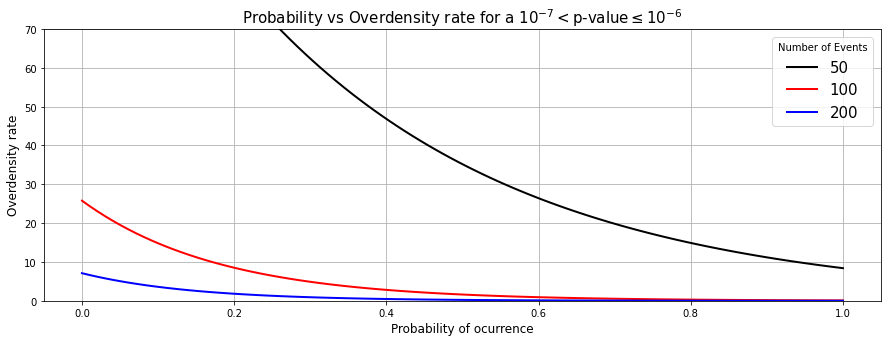

In [46]:
plt.figure(figsize= (15,5))
plt.plot(prob, y1, 'k-', linewidth=2, label='50')
plt.plot(prob, y2, 'r-', linewidth=2, label='100')
plt.plot(prob, y3, 'b-', linewidth=2, label='200')
plt.ylim(0,70)
plt.grid()
plt.title(r'Probability vs Overdensity rate for a $10^{-7} <$p-value$\leq 10^{-6}$ ', size=15)
plt.xlabel('Probability of ocurrence', size=12)
plt.ylabel('Overdensity rate', size=12)
plt.legend(title='Number of Events',prop={'size': 15});
#plt.savefig('pcurves5.jpg', format='jpg')